In [1]:
%load_ext autoreload
%autoreload 2

# add the parent directory in the path to import the packages
import sys
sys.path.append('../')

from WaterClassification.Radiometry import RadiometryDB
from WaterClassification.common import *
from WaterClassification.Fitting import BaseFit, MultiFit, FittingFunction, Functions, Fit, DfFit
from WaterClassification.Classification.clustering import *

from functools import partial
from itertools import product

from pathlib import Path

# Clustering Algorithm Performances
In the previous notebook we saw that with the same input features (wavelenghts) and same normalization, the different clustering algorithms achieved similar results until K=6.<br>
In this notebook we will increase the clustering to 15 to check if this convergence continues beyond K > 6.<br>
Additionally, we will check if the final clustering from the algorithms looks similar.


 ## Load the Database

In [2]:
# Open the Radiometry Database
db = RadiometryDB(r'D:\OneDrive - Agência Nacional de Águas\Data\GET-RadiometryDB')

db.load_radiometries(r_types=['Rrs', 'Rrs_OSOAA'], 
                     norm=True,                                                        # create the normalized bands and also the area
                     funcs=partial(calc_area, col_name='flatness', norm_band='700'),   # create the flatness band
                     qry="SPM > 0 and Status != 'Deleted' and Status != 'Suspicious'"  # clear deleted and no data
                    )
rrs = db.rdmtries['Rrs']

rrs.head(3)

Radiometries ['Rrs', 'Rrs_OSOAA'] loaded in dictionary .rdmtries


Area_2 Station_2    Measurement         Start_Date_2  SPM_2 Status_2  \
Id                                                                             
0   Descoberto   Ponto_1  20160318-1139  2016-03-18 11:39:00    7.0       Ok   
1   Descoberto   Ponto_2  20160318-1214  2016-03-18 12:14:00    8.4       Ok   
2   Descoberto   Ponto_3  20160318-1228  2016-03-18 12:28:00    5.8       Ok   

         Description_2  319       320       321  ...      n943      n944  \
Id                                               ...                       
0   GIANCARLO_ CAMP1_1  NaN  0.003272  0.003054  ...  0.000138  0.000127   
1   GIANCARLO_ CAMP1_2  NaN  0.002663  0.002460  ...  0.000193  0.000212   
2   GIANCARLO_ CAMP1_3  NaN  0.003356  0.003116  ...  0.000143  0.000146   

        n945      n946      n947      n948      n949      n950  n951  flatness  
Id                                                                              
0   0.000149  0.000184  0.000180  0.000186  0.000191  0.000213   NaN -1.480905  
1   0.000206  0.000210  0.000192  0.000204  0.000186  0.000189   NaN -1.484569  
2   0.000142  0.000146  0.000158  0.000165  0.000162  0.000154   NaN -1.755808  

[3 rows x 1289 columns]

In [3]:
# deleting outliers
rrs.drop(index=[410, 418, 390, 520, 409, 658], inplace=True, errors='ignore')
len(rrs)

869

In [4]:
fit_bands = s2bands + s2bands_norm + ['area', 'b865/b665']

In [5]:
high = rrs.query("SPM > 80")
low = rrs.query("SPM <= 80")

## First Tests - Default settings
### Fitting high SPM concentration (SPM > 80mg/l)

Everything as default. Fitting the same bands and the regular functions <b>(linear, exponential, power and nechad)</b><br>
We notice that the fitted curve doesn't follow the higher concentrations measurements. That will be addressed in the next test.

In [187]:
mfit = MultiFit(high, fit_bands, BaseFit.available_funcs, n_cpus=6, optimize_metric=True)
mfit.summary()

Data is ready! 260 records!


func       band     R^2      MSE     RMSE   RMSLE  \
Nechad on b740/b705  Nechad  b740/b705  0.8603  15614.5  124.958  0.2484   
Power on b740/b705    Power  b740/b705    0.85  16773.2  129.512  0.2493   
Power on b842/b705    Power  b842/b705   0.848  16990.8  130.349  0.2513   
Power on b865/b705    Power  b865/b705  0.8499  16786.2  129.562  0.2576   
Power on b783/b705    Power  b783/b705  0.8058  21709.8  147.342  0.2661   

                             SSE  \
Nechad on b740/b705  4.85612e+06   
Power on b740/b705   5.21648e+06   
Power on b842/b705   5.28413e+06   
Power on b865/b705   5.22052e+06   
Power on b783/b705   6.75174e+06   

                                                                params  qty  
Nechad on b740/b705  [38.226274240324116, 3.1724298887659006, -5.03...  311  
Power on b740/b705   [1613.2851545236895, 6.1765231107343075, 91.21...  311  
Power on b842/b705   [1665.688092015637, 3.8109530645018457, 86.068...  311  
Power on b865/b705   [1832.5390598747713, 3.3780523321701117, 86.47...  311  
Power on b783/b705   [1294.3916739960823, 5.908505189167565, 83.647...  311

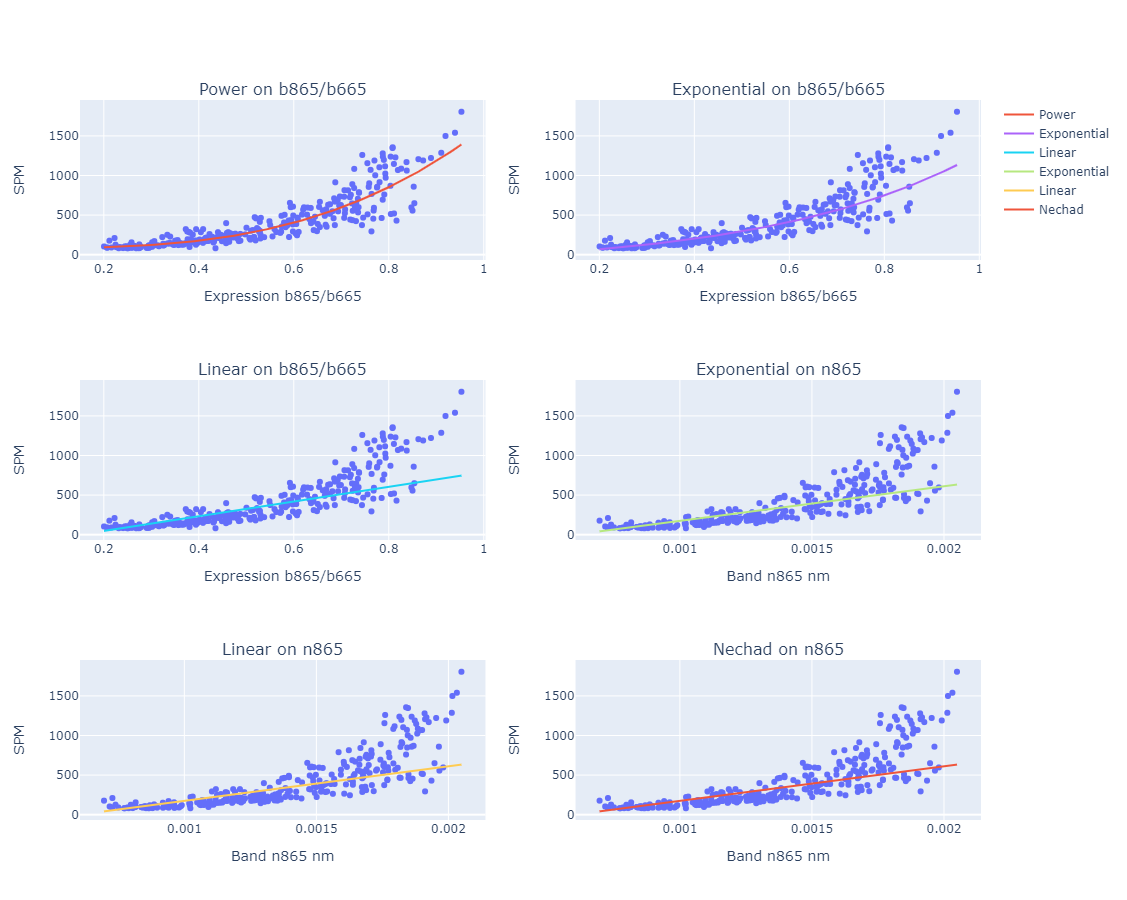

In [9]:
mfit.plot_best_fits(n=6, cols=2)

### Low concentrations <80mg/l

In [188]:
mfit = MultiFit(low, fit_bands, BaseFit.available_funcs, n_cpus=6, optimize_metric=True)
mfit.summary()

Data is ready! 260 records!


func band     R^2      MSE     RMSE   RMSLE  \
Power on 705              Power  705  0.6185  153.169  12.3762  0.5382   
Exponential on 705  Exponential  705  0.6405  144.325  12.0135  0.5489   
Nechad on 705            Nechad  705  0.6496  140.701  11.8618   0.549   
Linear on 705            Linear  705   0.641  144.148  12.0062  0.5503   
Nechad on 783            Nechad  783  0.6704  132.327  11.5034  0.5785   

                        SSE  \
Power on 705        85468.5   
Exponential on 705  80533.3   
Nechad on 705       78511.4   
Linear on 705       80434.6   
Nechad on 783       73838.8   

                                                               params  qty  
Power on 705        [3197.4262591382203, 1.2759852962843063, 0.663...  558  
Exponential on 705            [469.6155204090644, -469.9858718397086]  558  
Nechad on 705       [353.1856014019106, 1.6384842287381634, -0.420...  558  
Linear on 705               [1109.619270039856, -0.42088014482320446]  558  
Nechad on 783       [863.1178167672847, 1.0060142485783292, 0.2586...  558

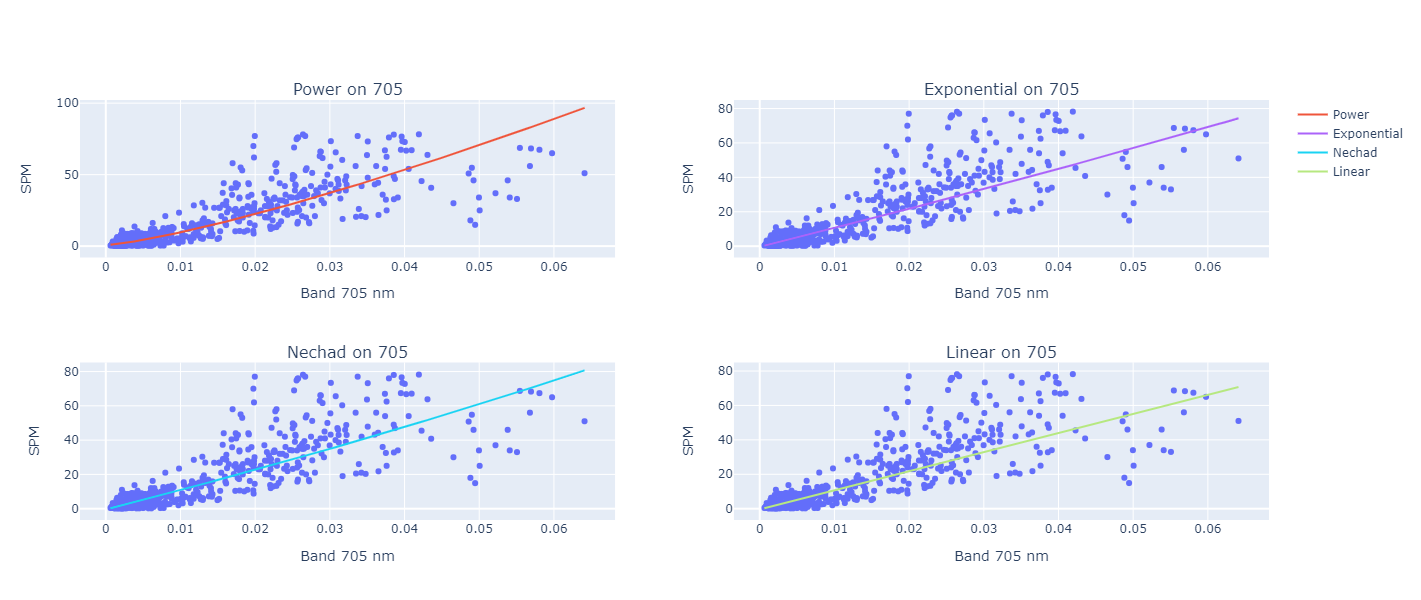

In [189]:
mfit.plot_best_fits(n=4, cols=2)

## Second test: without RMSLE optimization
Minimizing the sum of squares (method used to fit a curve) does not minimize the RMSLE. So, normally, after fitting the curve, we optimize the parameters using the RMSLE error as a cost function. <br>
In this test we will remove the <i>"a-posteriori"</i> optimization to assess its impact.<br>
From the graph, it is possible to note that we have a better fit on the higher concentrations and R^2 is improved. 

In [10]:
mfit = MultiFit(high, fit_bands, BaseFit.available_funcs, n_cpus=6, optimize_metric=False)

In [11]:
mfit.summary()

func       band     R^2      MSE     RMSE  \
Power on b865/b665              Power  b865/b665  0.8172    20441  142.972   
Exponential on b865/b665  Exponential  b865/b665  0.8038  21937.1  148.112   
Linear on 865                  Linear        865  0.2618  82533.4  287.286   
Nechad on 865                  Nechad        865  0.2618  82533.4  287.286   
Power on 940                    Power        940  0.3506  72600.8  269.445   

                           RMSLE          SSE  \
Power on b865/b665        0.2833  6.35716e+06   
Exponential on b865/b665  0.4035  6.82243e+06   
Linear on 865              0.611  2.56679e+07   
Nechad on 865              0.611  2.56679e+07   
Power on 940              0.6149  2.25788e+07   

                                                                     params  \
Power on b865/b665        [1693.4958551669101, 3.3199569206481727, 100.1...   
Exponential on b865/b665           [182.98035046346266, -272.0196538030946]   
Linear on 865                         [17093.37243897727, 17.6703353758597]   
Nechad on 865             [5440.987541124149, 711338.8520761713, 17.6704...   
Power on 940              [38356.7970630397, 1.0460209922145813, 46.5418...   

                          qty  
Power on b865/b665        311  
Exponential on b865/b665  311  
Linear on 865             311  
Nechad on 865             311  
Power on 940              311

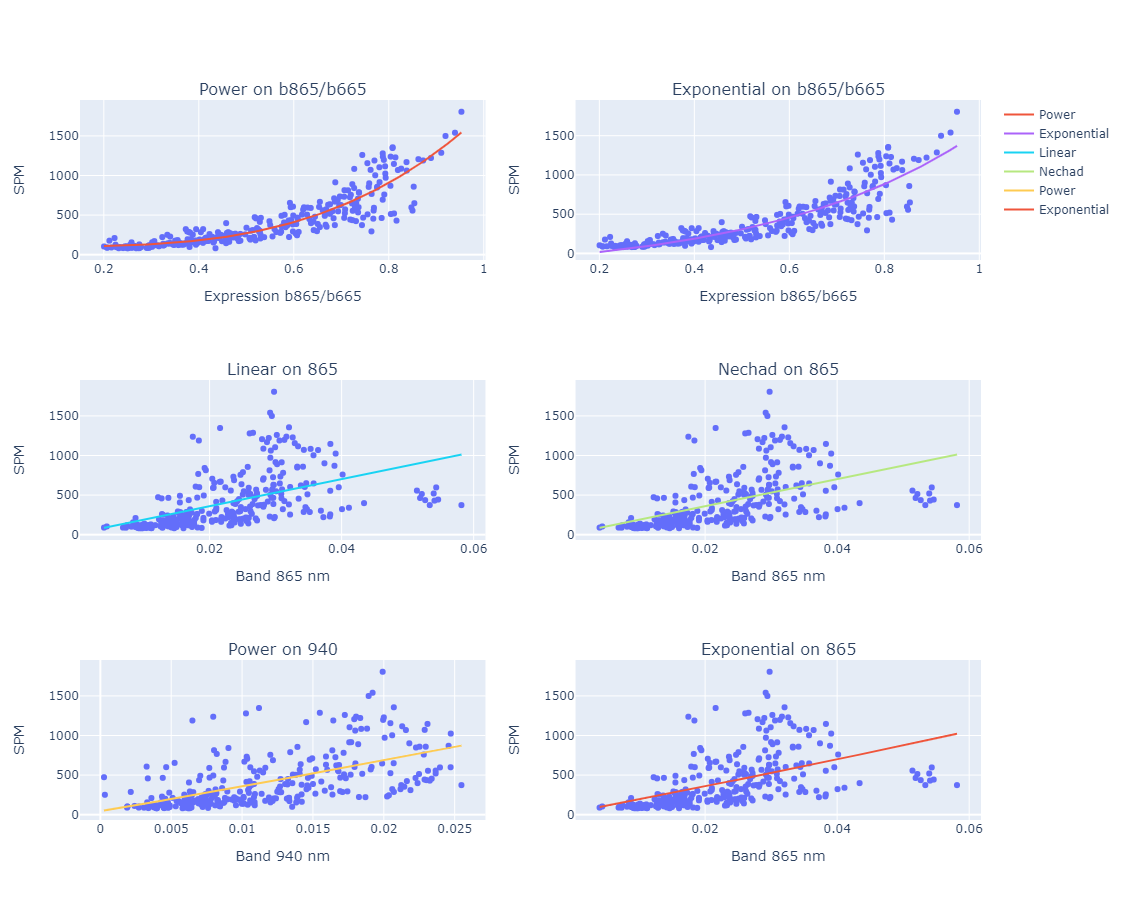

In [12]:
mfit.plot_best_fits(n=6, cols=2)

### Low concentrations <80mg/l

In [190]:
mfit = MultiFit(low, fit_bands, BaseFit.available_funcs, n_cpus=6, optimize_metric=False)
mfit.summary()

Data is ready! 260 records!


func band     R^2      MSE     RMSE   RMSLE  \
Linear on 705            Linear  705  0.6724   131.54  11.4691  0.5976   
Nechad on 705            Nechad  705  0.6724   131.54  11.4691  0.5976   
Exponential on 705  Exponential  705  0.6663  133.986  11.5752  0.6101   
Linear on 783            Linear  783  0.6936   123.03  11.0919  0.6552   
Nechad on 783            Nechad  783  0.6936   123.03  11.0919  0.6552   

                        SSE  \
Linear on 705       73399.5   
Nechad on 705       73399.5   
Exponential on 705    74764   
Linear on 783       68650.8   
Nechad on 783       68650.8   

                                                               params  qty  
Linear on 705                [1256.8180466992208, 0.4290263384568294]  558  
Nechad on 705       [400.05757142523873, 1483887.8586315985, 0.429...  558  
Exponential on 705            [516.2123134457353, -515.3301076585245]  558  
Linear on 783                 [2860.2125218657434, 2.139394403043928]  558  
Nechad on 783       [910.4338823085717, 1156650.7500026813, 2.1393...  558

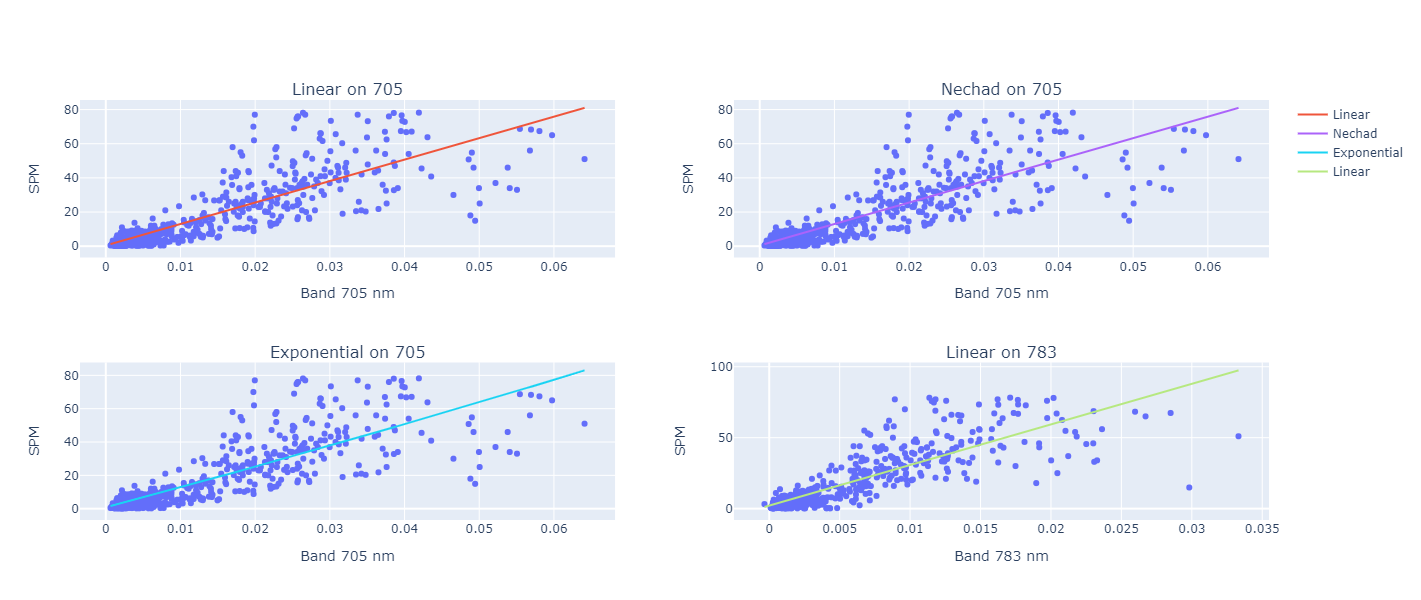

In [191]:
mfit.plot_best_fits(n=4, cols=2)

## Testing new ratios
Up to now, we've been testing the only the bands (raw and norm) and the ratio 865/665. <br>
In the following test we will be testing all the available ratios provided by the Sentinel 2 bands.<br>

The results were much improved by the addition of new ratios. Band 705nm seems to play an important role here.<br>
The regular ratio 865/665 appeas in 7th place. <br>
As conclusion, I think it is worthy to investigate these new ratios. For low SPM concentration we can see that there is no improvement (as expected)

In [192]:
ratios = [f'b{b1}/b{b2}' for b1, b2 in  product(s2bands, s2bands) if int(b1) > int(b2)]
fit_bands = s2bands + s2bands_norm + ratios

In [193]:
high_fit = MultiFit(high, fit_bands, BaseFit.available_funcs, n_cpus=6, optimize_metric=False, metric=BaseFit.r2)

high_fit.summary(n=10)

Data is ready! 260 records!


func       band     R^2      MSE     RMSE  \
Nechad on b740/b705            Nechad  b740/b705  0.8687  14676.3  121.146   
Power on b740/b705              Power  b740/b705  0.8652  15071.9  122.768   
Power on b865/b705              Power  b865/b705  0.8614  15493.6  124.474   
Power on b842/b705              Power  b842/b705  0.8591  15750.2    125.5   
Exponential on b865/b705  Exponential  b865/b705  0.8288  19141.7  138.354   
Exponential on b842/b705  Exponential  b842/b705  0.8197  20160.5  141.988   
Power on b865/b665              Power  b865/b665  0.8172    20441  142.972   
Power on b842/b665              Power  b842/b665  0.8161  20557.5  143.379   
Nechad on b783/b705            Nechad  b783/b705  0.8133  20876.5  144.487   
Power on b783/b705              Power  b783/b705  0.8129  20915.1  144.621   

                           RMSLE          SSE  \
Nechad on b740/b705        0.258  4.56432e+06   
Power on b740/b705        0.2685  4.68737e+06   
Power on b865/b705        0.2681  4.81852e+06   
Power on b842/b705        0.2628  4.89831e+06   
Exponential on b865/b705  0.5719  5.95307e+06   
Exponential on b842/b705  0.7851  6.26991e+06   
Power on b865/b665        0.2833  6.35716e+06   
Power on b842/b665        0.2763  6.39338e+06   
Nechad on b783/b705       0.2982  6.49261e+06   
Power on b783/b705        0.2714  6.50461e+06   

                                                                     params  \
Nechad on b740/b705       [48.30866727229953, 3.2535634901606723, -41.39...   
Power on b740/b705        [2072.6928124326264, 7.9555280453958055, 130.8...   
Power on b865/b705        [2255.0514449519223, 4.044775126642173, 117.53...   
Power on b842/b705        [2014.3995027741728, 4.580835158377067, 117.71...   
Exponential on b865/b705           [205.5603116825315, -341.57884845559033]   
Exponential on b842/b705          [187.49581762224668, -358.49457966558236]   
Power on b865/b665        [1693.4958551669101, 3.3199569206481727, 100.1...   
Power on b842/b665        [1515.0974534122593, 3.686400316152775, 97.219...   
Nechad on b783/b705       [59.06995832269009, 3.4921264866496444, -83.66...   
Power on b783/b705        [1426.97149552828, 6.499380719933458, 101.4356...   

                          qty  
Nechad on b740/b705       311  
Power on b740/b705        311  
Power on b865/b705        311  
Power on b842/b705        311  
Exponential on b865/b705  311  
Exponential on b842/b705  311  
Power on b865/b665        311  
Power on b842/b665        311  
Nechad on b783/b705       311  
Power on b783/b705        311

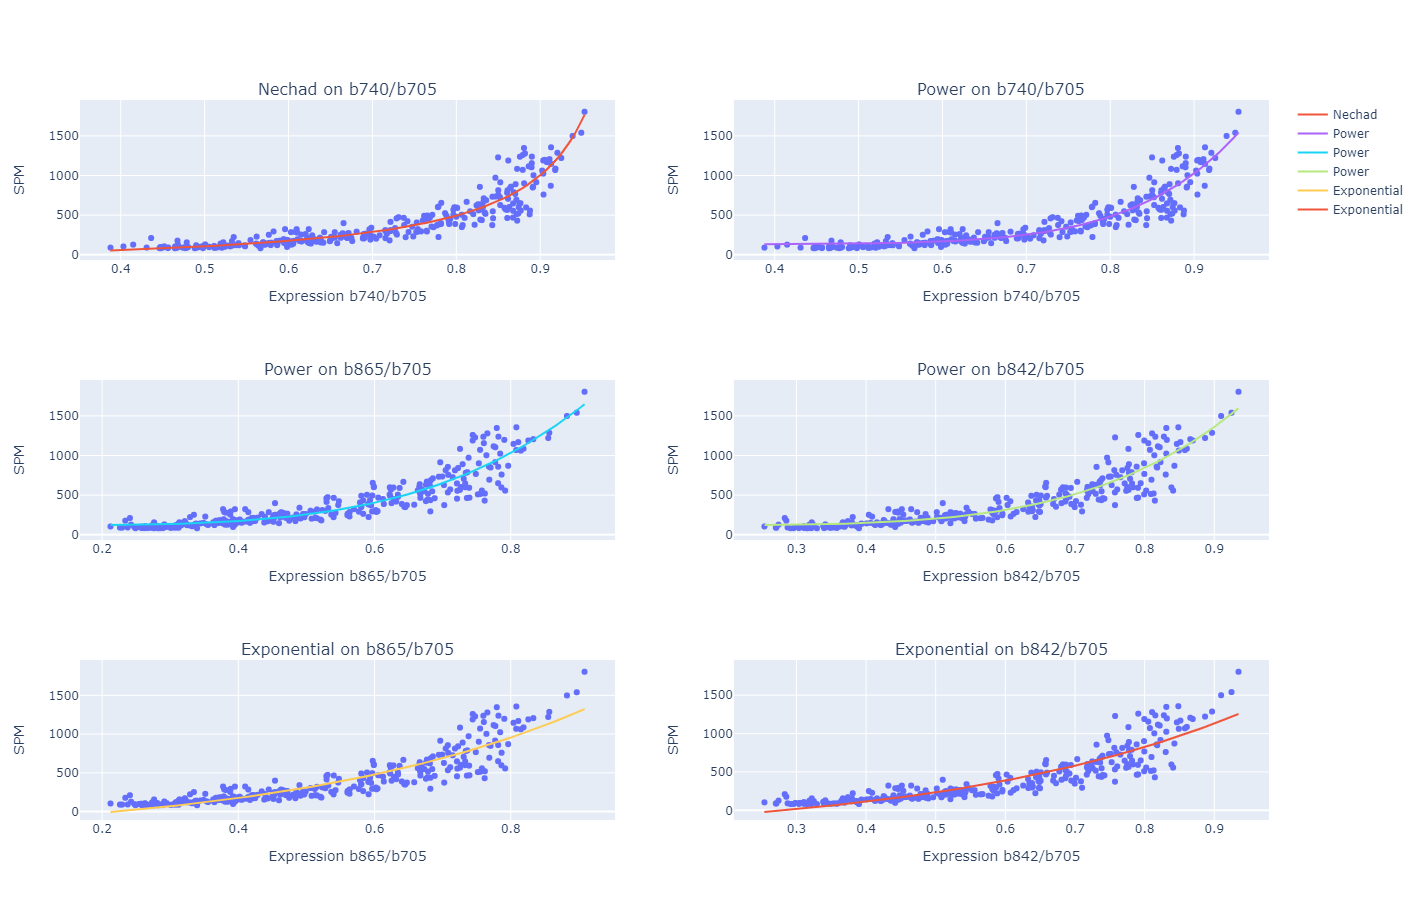

In [194]:
high_fit.plot_best_fits(n=6, cols=2)

In [195]:
low_fit = MultiFit(low, fit_bands, BaseFit.available_funcs, n_cpus=6, optimize_metric=False)
low_fit.summary()

Data is ready! 260 records!


func band     R^2      MSE     RMSE   RMSLE  \
Linear on 705            Linear  705  0.6724   131.54  11.4691  0.5976   
Nechad on 705            Nechad  705  0.6724   131.54  11.4691  0.5976   
Exponential on 705  Exponential  705  0.6663  133.986  11.5752  0.6101   
Linear on 783            Linear  783  0.6936   123.03  11.0919  0.6552   
Nechad on 783            Nechad  783  0.6936   123.03  11.0919  0.6552   

                        SSE  \
Linear on 705       73399.5   
Nechad on 705       73399.5   
Exponential on 705    74764   
Linear on 783       68650.8   
Nechad on 783       68650.8   

                                                               params  qty  
Linear on 705                [1256.8180466992208, 0.4290263384568294]  558  
Nechad on 705       [400.05757142523873, 1483887.8586315985, 0.429...  558  
Exponential on 705            [516.2123134457353, -515.3301076585245]  558  
Linear on 783                 [2860.2125218657434, 2.139394403043928]  558  
Nechad on 783       [910.4338823085717, 1156650.7500026813, 2.1393...  558

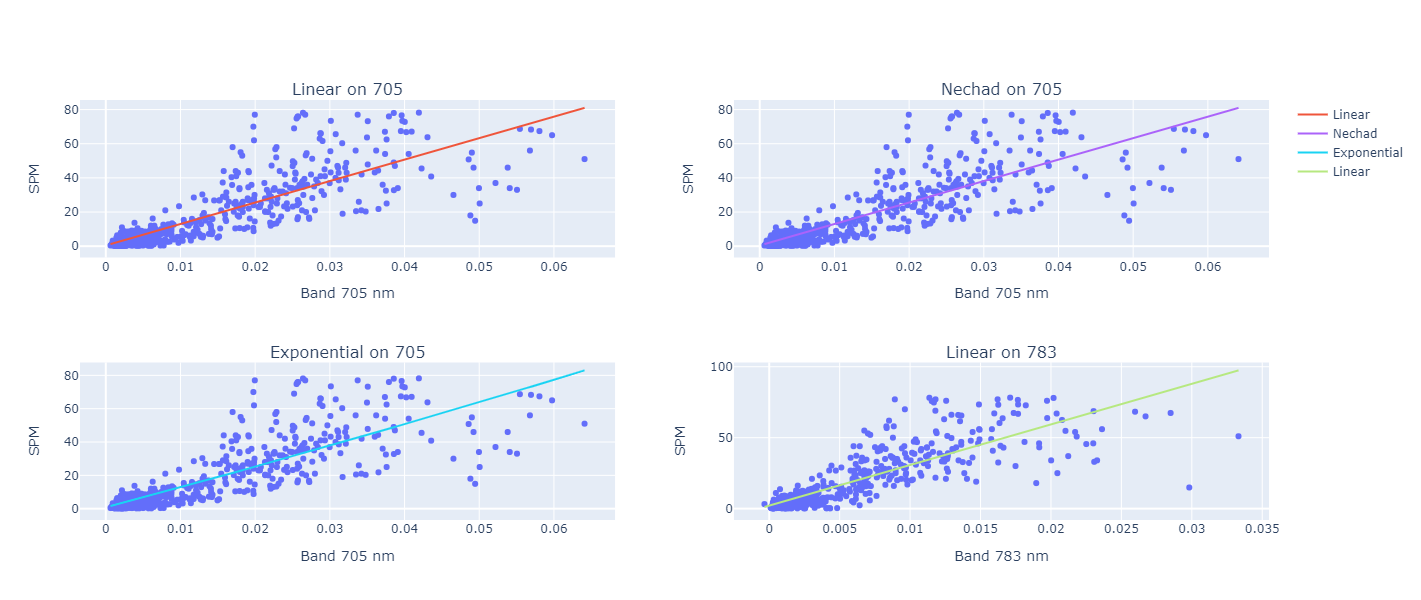

In [196]:
low_fit.plot_best_fits(n=4, cols=2)

# New Fitting Function - Norm
In this test, we will fit a new function proposed by XXXX: <br>
$\displaystyle SPM=a\frac{(R-R_0)^b}{R_{sat}-R}$ <br>
Results shows that this new function has no good results were obtained using this function either for low or high concentrations.

In [198]:
def norm_func(x, a, r0, b, rsat): return (a*(x-r0)**b)/(rsat-x)
BaseFit.available_funcs = BaseFit.available_funcs + [FittingFunction('Norm', norm_func)]
BaseFit.available_funcs

[Linear, Exponential, Power, Nechad, Norm, Norm]

In [199]:
ratios = [f'b{b1}/b{b2}' for b1, b2 in  product(s2bands, s2bands) if int(b1) > int(b2)]
fit_bands = s2bands + s2bands_norm + ratios
high_fit = MultiFit(high, fit_bands, BaseFit.available_funcs, n_cpus=6, optimize_metric=False)

Data is ready! 390 records!


In [205]:
df = high_fit.summary(n=None)
df.head()

func       band     R^2      MSE     RMSE   RMSLE  \
Nechad on b740/b705  Nechad  b740/b705  0.8687  14676.3  121.146   0.258   
Power on b842/b705    Power  b842/b705  0.8591  15750.2    125.5  0.2628   
Power on b865/b705    Power  b865/b705  0.8614  15493.6  124.474  0.2681   
Power on b740/b705    Power  b740/b705  0.8652  15071.9  122.768  0.2685   
Power on b783/b705    Power  b783/b705  0.8129  20915.1  144.621  0.2714   

                             SSE  \
Nechad on b740/b705  4.56432e+06   
Power on b842/b705   4.89831e+06   
Power on b865/b705   4.81852e+06   
Power on b740/b705   4.68737e+06   
Power on b783/b705   6.50461e+06   

                                                                params  qty  
Nechad on b740/b705  [48.30866727229953, 3.2535634901606723, -41.39...  311  
Power on b842/b705   [2014.3995027741728, 4.580835158377067, 117.71...  311  
Power on b865/b705   [2255.0514449519223, 4.044775126642173, 117.53...  311  
Power on b740/b705   [2072.6928124326264, 7.9555280453958055, 130.8...  311  
Power on b783/b705   [1426.97149552828, 6.499380719933458, 101.4356...  311

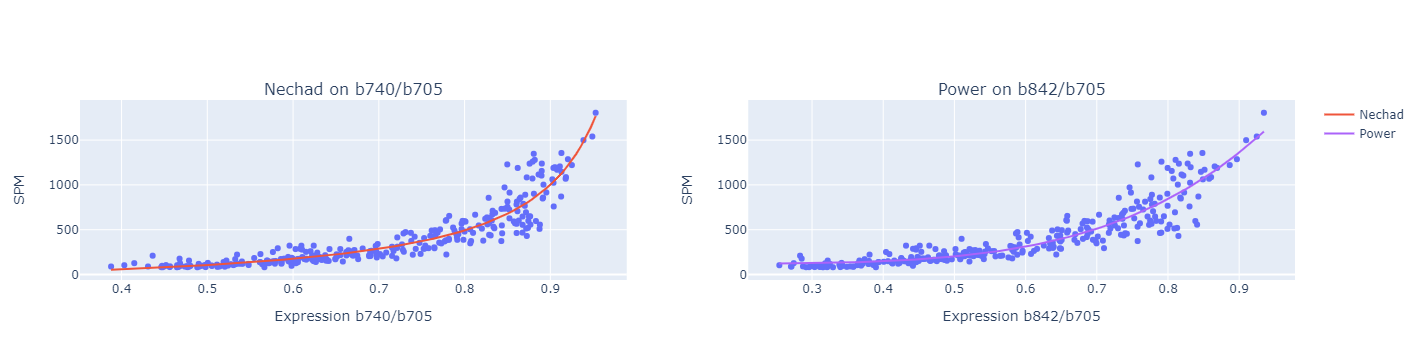

In [206]:
high_fit.plot_best_fits(n=2, cols=2)

In [207]:
low_fit = MultiFit(low, fit_bands, BaseFit.available_funcs, n_cpus=6, optimize_metric=False)

Data is ready! 390 records!


In [208]:
low_fit.summary()

func band     R^2      MSE     RMSE   RMSLE  \
Linear on 705            Linear  705  0.6724   131.54  11.4691  0.5976   
Nechad on 705            Nechad  705  0.6724   131.54  11.4691  0.5976   
Exponential on 705  Exponential  705  0.6663  133.986  11.5752  0.6101   
Linear on 783            Linear  783  0.6936   123.03  11.0919  0.6552   
Nechad on 783            Nechad  783  0.6936   123.03  11.0919  0.6552   

                        SSE  \
Linear on 705       73399.5   
Nechad on 705       73399.5   
Exponential on 705    74764   
Linear on 783       68650.8   
Nechad on 783       68650.8   

                                                               params  qty  
Linear on 705                [1256.8180466992208, 0.4290263384568294]  558  
Nechad on 705       [400.05757142523873, 1483887.8586315985, 0.429...  558  
Exponential on 705            [516.2123134457353, -515.3301076585245]  558  
Linear on 783                 [2860.2125218657434, 2.139394403043928]  558  
Nechad on 783       [910.4338823085717, 1156650.7500026813, 2.1393...  558

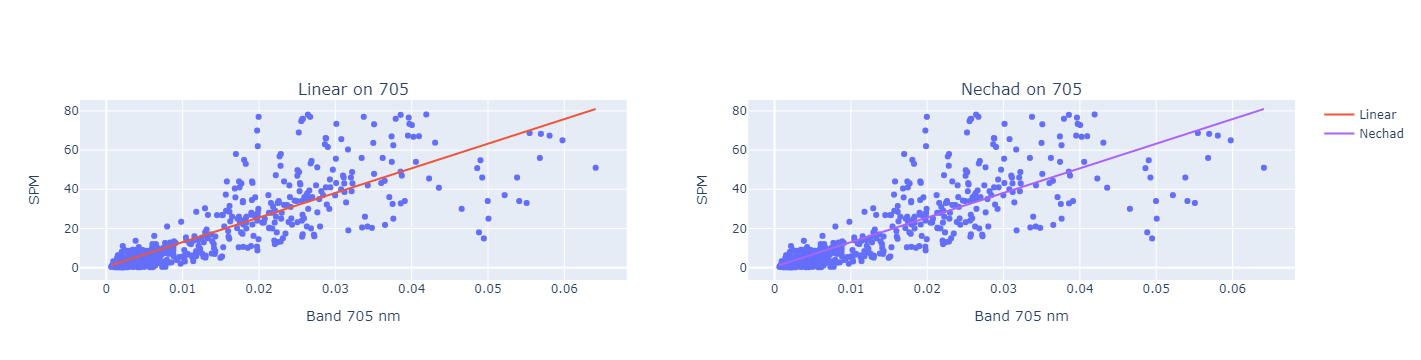

In [209]:
low_fit.plot_best_fits(n=2, cols=2)

## Testing Normalized Differences
For this next test, I've replaced the regular band ratios for normalized difference expressions:<br>
$\displaystyle \frac{R_1-R_2}{R_1+R_2}$<br>
The results are worst than those obtained using the ratios on the raw bands.

In [24]:
norm_difs = [f'(b{b1}-b{b2})/(b{b1}+b{b2})' for b1, b2 in  product(s2bands, s2bands) if int(b1) > int(b2)]
fit_bands = s2bands + s2bands_norm + norm_difs
high_fit = MultiFit(high, fit_bands, BaseFit.available_funcs, n_cpus=6, optimize_metric=False)

In [25]:
high_fit.summary()

func                     band  \
Exponential on (b940-b560)/(b940+b560)  Exponential  (b940-b560)/(b940+b560)   
Exponential on (b940-b490)/(b940+b490)  Exponential  (b940-b490)/(b940+b490)   
Exponential on (b940-b443)/(b940+b443)  Exponential  (b940-b443)/(b940+b443)   
Linear on 865                                Linear                      865   
Nechad on 865                                Nechad                      865   

                                           R^2      MSE     RMSE   RMSLE  \
Exponential on (b940-b560)/(b940+b560)  0.5658  48543.6  220.326  0.5574   
Exponential on (b940-b490)/(b940+b490)  0.4693  59334.1  243.586  0.5652   
Exponential on (b940-b443)/(b940+b443)  0.3841  68855.7  262.404  0.6056   
Linear on 865                           0.2618  82533.4  287.286   0.611   
Nechad on 865                           0.2618  82533.4  287.286   0.611   

                                                SSE  \
Exponential on (b940-b560)/(b940+b560)  1.50971e+07   
Exponential on (b940-b490)/(b940+b490)  1.84529e+07   
Exponential on (b940-b443)/(b940+b443)  2.14141e+07   
Linear on 865                           2.56679e+07   
Nechad on 865                           2.56679e+07   

                                                                                   params  \
Exponential on (b940-b560)/(b940+b560)          [1675.9269017920296, -165.84217218098024]   
Exponential on (b940-b490)/(b940+b490)            [745.7582843614917, -30.71549962449558]   
Exponential on (b940-b443)/(b940+b443)           [482.34481655959405, 26.482985604355385]   
Linear on 865                                       [17093.37243897727, 17.6703353758597]   
Nechad on 865                           [5440.987541124149, 711338.8520761713, 17.6704...   

                                        qty  
Exponential on (b940-b560)/(b940+b560)  311  
Exponential on (b940-b490)/(b940+b490)  311  
Exponential on (b940-b443)/(b940+b443)  311  
Linear on 865                           311  
Nechad on 865                           311

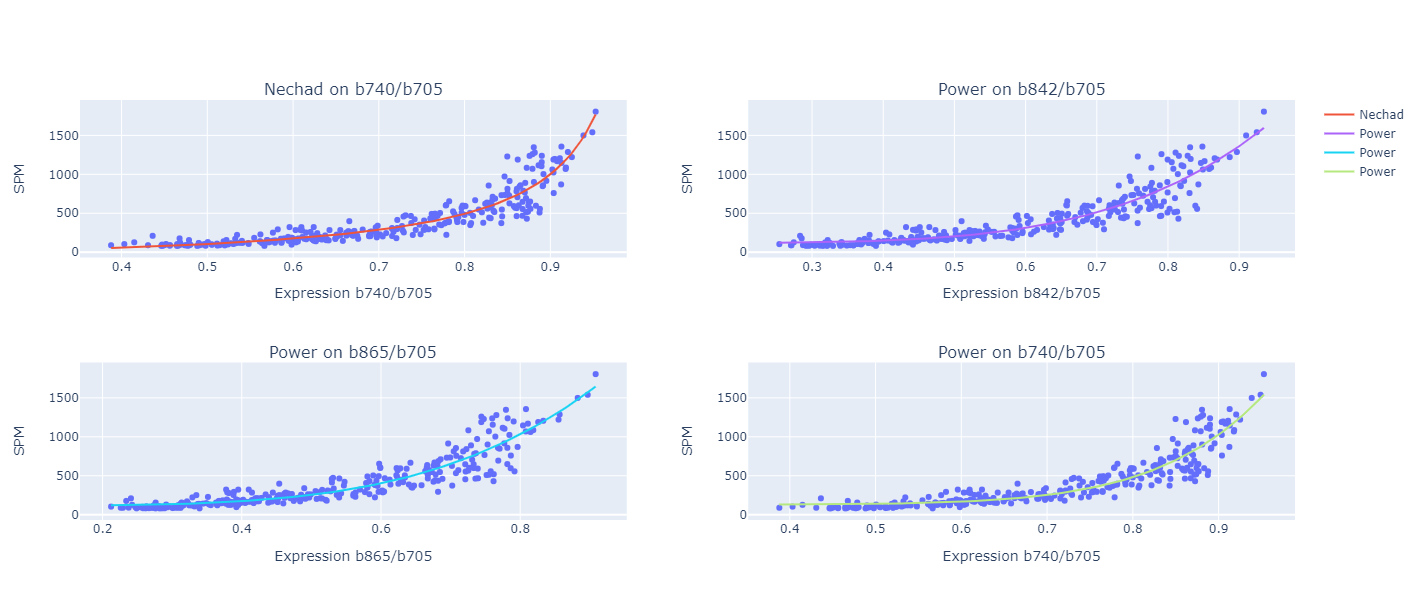

In [210]:
high_fit.plot_best_fits(n=4, cols=2)

In [211]:
low_fit = MultiFit(low, fit_bands, BaseFit.available_funcs, n_cpus=6, optimize_metric=False)

Data is ready! 390 records!


In [212]:
low_fit.summary()

func band     R^2      MSE     RMSE   RMSLE  \
Linear on 705            Linear  705  0.6724   131.54  11.4691  0.5976   
Nechad on 705            Nechad  705  0.6724   131.54  11.4691  0.5976   
Exponential on 705  Exponential  705  0.6663  133.986  11.5752  0.6101   
Linear on 783            Linear  783  0.6936   123.03  11.0919  0.6552   
Nechad on 783            Nechad  783  0.6936   123.03  11.0919  0.6552   

                        SSE  \
Linear on 705       73399.5   
Nechad on 705       73399.5   
Exponential on 705    74764   
Linear on 783       68650.8   
Nechad on 783       68650.8   

                                                               params  qty  
Linear on 705                [1256.8180466992208, 0.4290263384568294]  558  
Nechad on 705       [400.05757142523873, 1483887.8586315985, 0.429...  558  
Exponential on 705            [516.2123134457353, -515.3301076585245]  558  
Linear on 783                 [2860.2125218657434, 2.139394403043928]  558  
Nechad on 783       [910.4338823085717, 1156650.7500026813, 2.1393...  558

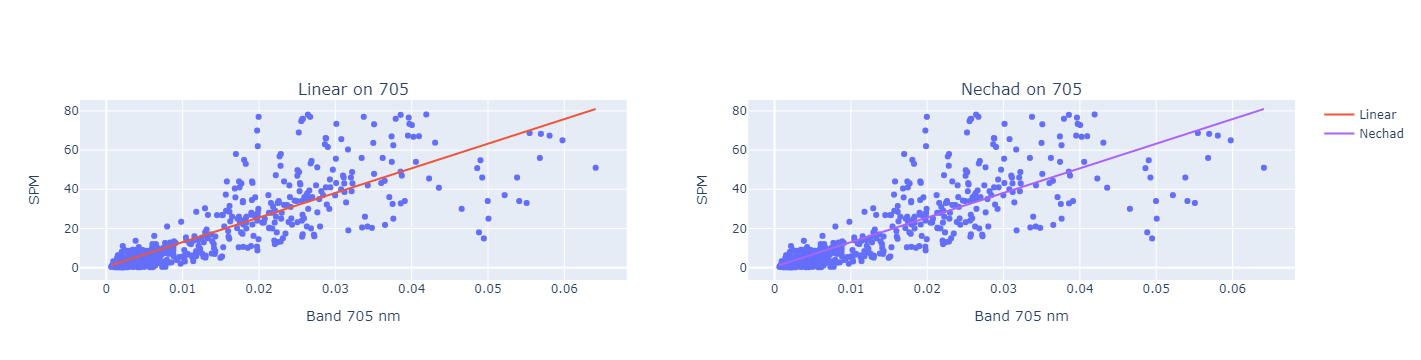

In [213]:
low_fit.plot_best_fits(n=2, cols=2)

## Multiple Linear Regression
In this next test we will investigate if it makes sense to perform a regression using more than 1 independent variable. To validate the assumption I will include 2 variables in the simplest linear function to see how it performs. Apparently combining function can improve the final results.

In [216]:
def lin2(x, a, b, c):
    return a*x[:, 0] + b*x[:, 1] + c

linear2 = FittingFunction('Linear2', lin2)

In [221]:
fit_bands = s2bands
mfit = MultiFit(high, fit_bands, [Functions.linear], optimize_metric=True)

mfit.summary()

Data is ready! 10 records!


func band     R^2      MSE     RMSE   RMSLE          SSE  \
Linear on 865  Linear  865  0.2181  87415.3  295.661  0.5631  2.71862e+07   
Linear on 842  Linear  842  0.1743  92317.1  303.837  0.5861  2.87106e+07   
Linear on 940  Linear  940  0.2754  81015.8  284.633  0.5877  2.51959e+07   
Linear on 740  Linear  740  0.0307   108365  329.189  0.6711  3.37016e+07   
Linear on 783  Linear  783  0.0192   109657  331.144   0.674  3.41032e+07   

                                                 params  qty  
Linear on 865  [16072.981110699255, -28.17122624065204]  311  
Linear on 842   [14761.17611713526, -34.38173786775512]  311  
Linear on 940    [23995.65768220446, 57.05989842152745]  311  
Linear on 740   [11796.25635004471, -35.34541598689453]  311  
Linear on 783  [11540.095633293287, -39.45912226726441]  311

In [57]:
# Linear using band 865
Fit(Functions.linear, x=high['865'], y=high['SPM'],optimize_metric=BaseFit.rmsle)

Linear - qty: 311 | R^2: 0.2181 MSE: 87415.2773 RMSE: 295.6607 RMSLE: 0.5631 SSE: 27186151.2436 

In [99]:
# multiple Linear regression using 2 bands 865 and 842
Fit(linear2, x=high[['865', '842']].to_numpy(), y=high['SPM'], optimize_metric=BaseFit.rmsle)

Linear2 - qty: 311 | R^2: 0.4728 MSE: 58946.3232 RMSE: 242.7886 RMSLE: 0.4465 SSE: 18332306.5146 

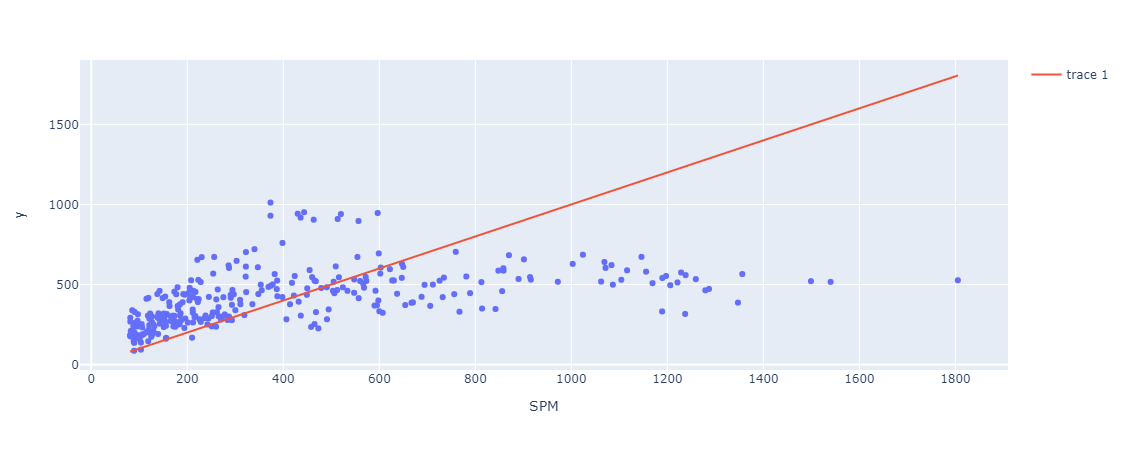

In [100]:
dffit = DfFit(high, Functions.linear, expr_x='865', expr_y='SPM')
dffit.plot_pred_vs_targ()

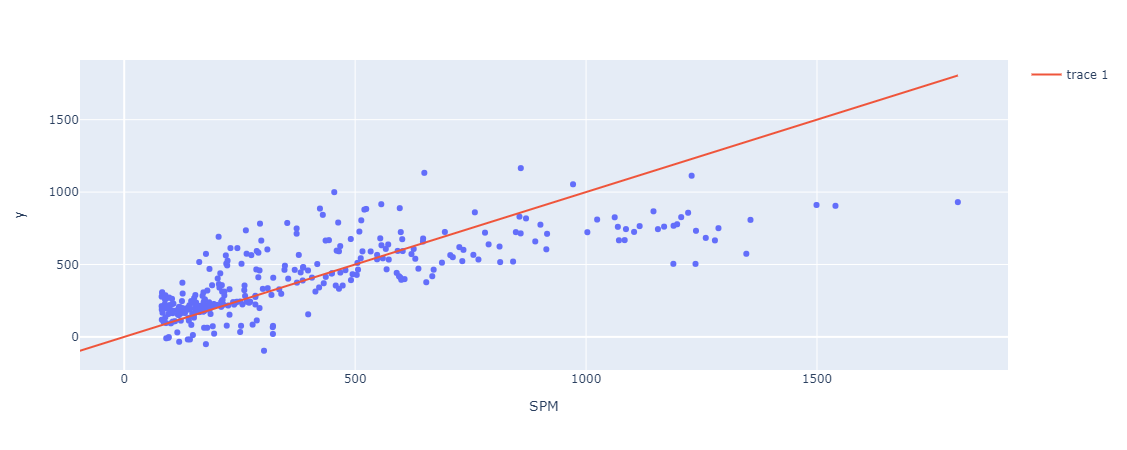

In [182]:
dffit = DfFit(high, linear2, ('865', '842'), expr_y='SPM', optimize_metric=None)
dffit.plot_pred_vs_targ()

# Testing 2 var functions

In [7]:
ratios = [f'b{b1}/b{b2}' for b1, b2 in  product(s2bands, s2bands) if int(b1) > int(b2)]
fit_bands = s2bands + s2bands_norm + ratios

# include the 2 variables options
fit_bands = fit_bands + [t for t in product(fit_bands, fit_bands) if t[0] != t[1]]
len(fit_bands)

4225

In [143]:
funcs = [Functions.linear, Functions.power, Functions.nechad, Functions.linear2, Functions.lin_nechad, Functions.nechad3,
         Functions.power2, Functions.expo2, Functions.lin_power, Functions.lin_expo, Functions.power_expo, Functions.power_nechad, Functions.expo_nechad]

In [144]:
mfit = MultiFit(high, fit_bands, funcs=funcs, n_cpus=6)

Data is ready! 42445 records!


In [149]:
df = mfit.summary(n=None)
df

func  \
Linear_Nechad on ('b740/b665', 'b740/b705')  Linear_Nechad   
Power_Nechad on ('b740/b665', 'b740/b705')    Power_Nechad   
Power2 on ('b740/b705', 'b865/b705')                Power2   
Power2 on ('b865/b705', 'b740/b705')                Power2   
Power_Nechad on ('b865/b665', 'b842/b705')    Power_Nechad   
...                                                    ...   
Expo_Nechad on ('b940/b783', 'b560/b490')      Expo_Nechad   
Expo_Nechad on ('b940/b783', 'b665/b490')      Expo_Nechad   
Expo_Nechad on ('b940/b842', 'b560/b490')      Expo_Nechad   
Expo_Nechad on ('b940/b842', 'b705/b560')      Expo_Nechad   
Expo_Nechad on ('b940/b865', 'b705/b560')      Expo_Nechad   

                                                               band     R^2  \
Linear_Nechad on ('b740/b665', 'b740/b705')  (b740/b665, b740/b705)  0.8699   
Power_Nechad on ('b740/b665', 'b740/b705')   (b740/b665, b740/b705)  0.8699   
Power2 on ('b740/b705', 'b865/b705')         (b740/b705, b865/b705)  0.8716   
Power2 on ('b865/b705', 'b740/b705')         (b865/b705, b740/b705)  0.8716   
Power_Nechad on ('b865/b665', 'b842/b705')   (b865/b665, b842/b705)  0.8638   
...                                                             ...     ...   
Expo_Nechad on ('b940/b783', 'b560/b490')    (b940/b783, b560/b490)    None   
Expo_Nechad on ('b940/b783', 'b665/b490')    (b940/b783, b665/b490)    None   
Expo_Nechad on ('b940/b842', 'b560/b490')    (b940/b842, b560/b490)    None   
Expo_Nechad on ('b940/b842', 'b705/b560')    (b940/b842, b705/b560)    None   
Expo_Nechad on ('b940/b865', 'b705/b560')    (b940/b865, b705/b560)    None   

                                                 MSE     RMSE   RMSLE  \
Linear_Nechad on ('b740/b665', 'b740/b705')  14545.3  120.604  0.2465   
Power_Nechad on ('b740/b665', 'b740/b705')   14544.6  120.601  0.2467   
Power2 on ('b740/b705', 'b865/b705')         14351.2  119.796  0.2481   
Power2 on ('b865/b705', 'b740/b705')         14351.2  119.796  0.2481   
Power_Nechad on ('b865/b665', 'b842/b705')     15226  123.394  0.2485   
...                                              ...      ...     ...   
Expo_Nechad on ('b940/b783', 'b560/b490')       None     None    None   
Expo_Nechad on ('b940/b783', 'b665/b490')       None     None    None   
Expo_Nechad on ('b940/b842', 'b560/b490')       None     None    None   
Expo_Nechad on ('b940/b842', 'b705/b560')       None     None    None   
Expo_Nechad on ('b940/b865', 'b705/b560')       None     None    None   

                                                     SSE  \
Linear_Nechad on ('b740/b665', 'b740/b705')   4.5236e+06   
Power_Nechad on ('b740/b665', 'b740/b705')   4.52337e+06   
Power2 on ('b740/b705', 'b865/b705')         4.46321e+06   
Power2 on ('b865/b705', 'b740/b705')         4.46321e+06   
Power_Nechad on ('b865/b665', 'b842/b705')   4.73529e+06   
...                                                  ...   
Expo_Nechad on ('b940/b783', 'b560/b490')           None   
Expo_Nechad on ('b940/b783', 'b665/b490')           None   
Expo_Nechad on ('b940/b842', 'b560/b490')           None   
Expo_Nechad on ('b940/b842', 'b705/b560')           None   
Expo_Nechad on ('b940/b865', 'b705/b560')           None   

                                                                                        params  \
Linear_Nechad on ('b740/b665', 'b740/b705')  [-284.37294987949656, 198.48769400297812, 1.05...   
Power_Nechad on ('b740/b665', 'b740/b705')   [-265.0055597218628, 1.2958848816087807, 201.3...   
Power2 on ('b740/b705', 'b865/b705')         [1247.5714846077492, 5.506518722149511, 1562.9...   
Power2 on ('b865/b705', 'b740/b705')         [1563.0215720522094, 8.628642128653244, 1247.6...   
Power_Nechad on ('b865/b665', 'b842/b705')   [-745.4545236244647, 1.2198212254693381, 572.6...   
...                                                                                        ...   
Expo_Nechad on ('b940/b783', 'b560/b490')                                   

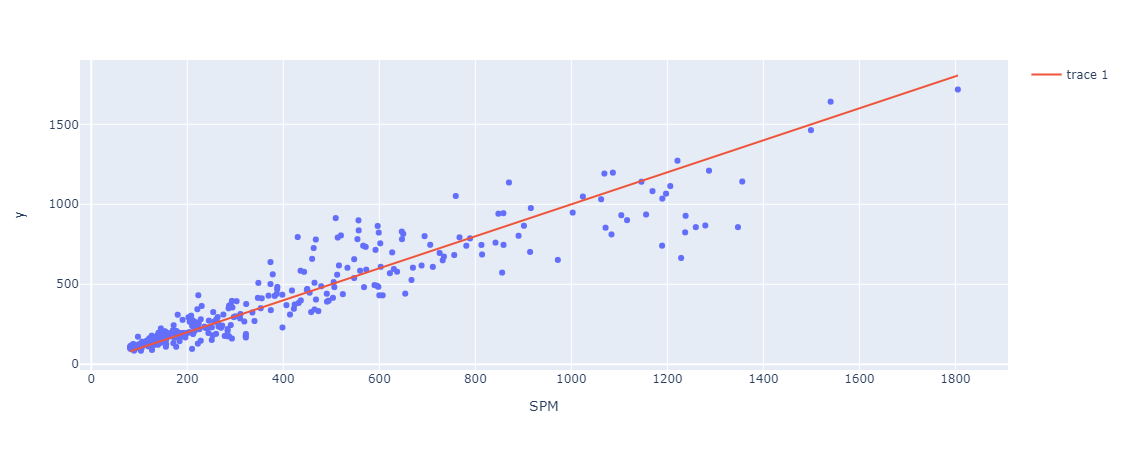

In [146]:
mfit.best_fit.plot_pred_vs_targ()

In [150]:
low_mfit = MultiFit(low, fit_bands, funcs=funcs, n_cpus=6)

Data is ready! 42445 records!


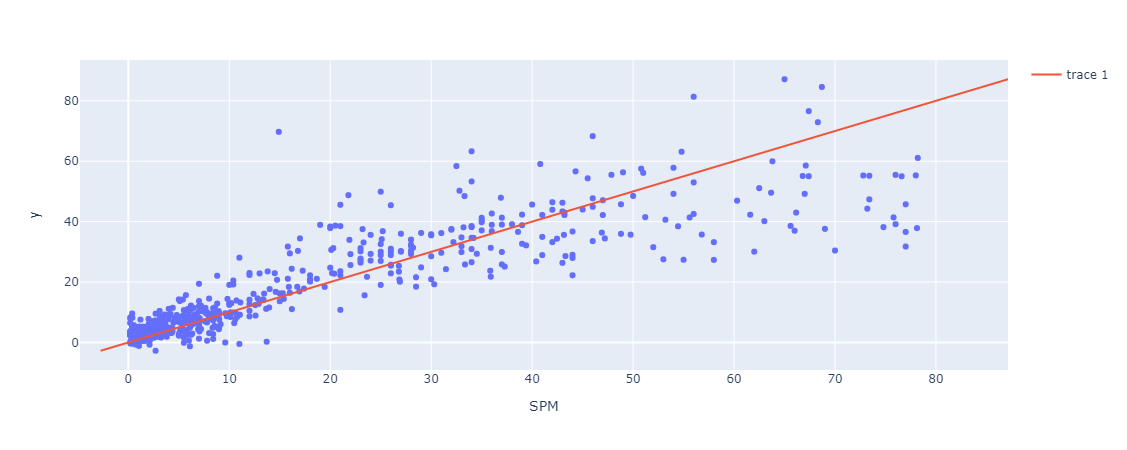

In [153]:
low_mfit.best_fit.plot_pred_vs_targ()

In [152]:
df = low_mfit.summary(n=None)
df.head(5)

func        band     R^2      MSE  \
Power_Expo on ('443', '705')      Power_Expo  (443, 705)  0.7689  92.8017   
Power_Expo on ('443', '665')      Power_Expo  (443, 665)  0.7143  114.707   
Linear_Power on ('665', '443')  Linear_Power  (665, 443)  0.7191    112.8   
Power_Nechad on ('443', '665')  Power_Nechad  (443, 665)  0.7191    112.8   
Power_Expo on ('490', '665')      Power_Expo  (490, 665)  0.7111  115.989   

                                   RMSE   RMSLE      SSE  \
Power_Expo on ('443', '705')     9.6334  0.5612  51783.3   
Power_Expo on ('443', '665')    10.7101  0.5633  64006.5   
Linear_Power on ('665', '443')  10.6207  0.5662  62942.3   
Power_Nechad on ('443', '665')  10.6207  0.5662  62942.3   
Power_Expo on ('490', '665')    10.7698  0.5705  64721.9   

                                                                           params  \
Power_Expo on ('443', '705')    [-22003.169413168074, 1.6050957752877204, 787....   
Power_Expo on ('443', '665')    [-12709.616432829773, 1.4373059662577896, 732....   
Linear_Power on ('665', '443')  [1804.324958857987, -9558.59020702336, 1.35869...   
Power_Nechad on ('443', '665')  [-9558.101902180568, 1.3586749960545725, 1804....   
Power_Expo on ('490', '665')    [-17542.88848171396, 1.6358614447045046, 744.8...   

                                qty  
Power_Expo on ('443', '705')    558  
Power_Expo on ('443', '665')    558  
Linear_Power on ('665', '443')  558  
Power_Nechad on ('443', '665')  558  
Power_Expo on ('490', '665')    558

# Comparing new functions to clustering baseline 
### (k-means-1nm-rawnorm-standard)

In [222]:
kmeans = load_obj(f'../data/k-means_1nm_rawnorm_Standard.multicluster')
kmeans.sort_by_variable()

In [ ]:
kmeans_nfuncs = MultiClustering(rrs, all_wls+all_wls_norm, range_clusters=(1, 7), algo='k-means', norm='Standard')
kmeans_nfuncs.fit(fit_bands, funcs, n_cpus=6, optimize_metric=True)

In [ ]:
ratios = [f'b{b1}/b{b2}' for b1, b2 in  product(s2bands, s2bands) if int(b1) > int(b2)]
fit_bands = s2bands + s2bands_norm + ratios
kmeans_ratios = MultiClustering(rrs, all_wls+all_wls_norm, range_clusters=(1, 7), algo='k-means', norm='Standard')
kmeans_ratios.fit(fit_bands, BaseFit.available_funcs[:4], n_cpus=6, optimize_metric=True)

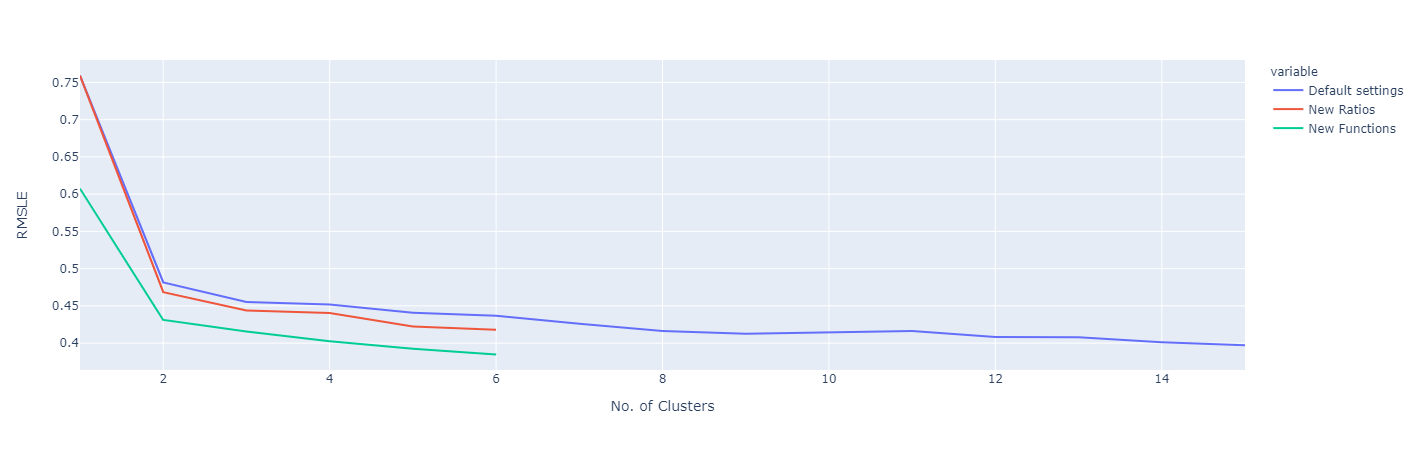

In [227]:
MultiClustering.plot_metric_by_cluster([kmeans, kmeans_ratios, kmeans_nfuncs], ['Default settings', 'New Ratios', 'New Functions'])
# kmeans_nfuncs.plot_parameter()

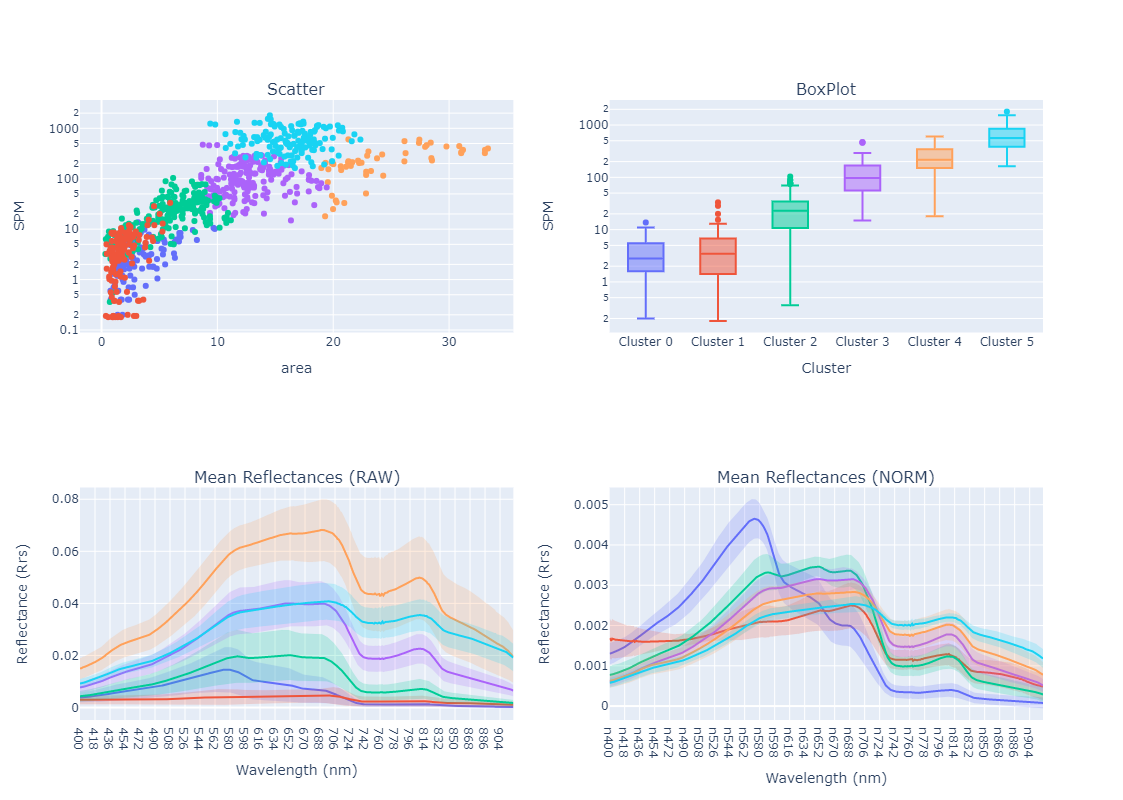

In [167]:
kmeans_nfuncs[6].plot_summary()

In [174]:
kmeans_nfuncs[6].group_fit.summary()

func                    band     R^2         MSE      RMSE  \
0             Linear2        (705, b783/b490)  0.3871      4.6539    2.1573   
1              Power2        (665, b560/b490)  0.6041      9.2609    3.0432   
2              Power2              (443, 783)  0.5962    139.6525   11.8175   
3        Power_Nechad  (b740/b705, b842/b490)  0.7764   1513.2607   38.9007   
4        Power_Nechad        (865, b842/b490)  0.8079   4492.9744   67.0297   
5              Power2        (b740/b705, 665)  0.8331  19620.1008  140.0718   
overall           NaN                     NaN  0.9473   3954.8729   62.8878   

          RMSLE           SSE  \
0        0.4250  5.770816e+02   
1        0.5756  1.222434e+03   
2        0.3870  3.114251e+04   
3        0.3288  2.905461e+05   
4        0.2153  2.291417e+05   
5        0.2010  2.884155e+06   
overall  0.3847  3.436785e+06   

                                                    params  qty  
0        [313.3731377225066, 9.487917139637462, 0.19614...  124  
1        [106699.79588227396, 2.163166181345808, 0.9700...  132  
2        [-15766.033191441822, 1.6635352660570928, 9731...  223  
3        [1139.0777528728547, 3.9707664111738135, 0.017...  192  
4        [12978.48371611556, 1.098146703977688, -5.6016...   51  
5        [2058.5015881500676, 8.504515163787865, 0.7822...  147  
overall                                               None    0

In [175]:
kmeans[6].group_fit.summary()

func       band     R^2         MSE      RMSE   RMSLE  \
0              Power        705  0.3578      5.9404    2.4373  0.4524   
1        Exponential        705  0.4695     11.6128    3.4077  0.6213   
2        Exponential        783  0.5227    206.0866   14.3557  0.4214   
3              Power  b865/b665  0.6496   2353.7557   48.5155  0.4344   
4        Exponential       n865  0.7420   6697.9107   81.8408  0.2405   
5              Power  b865/b665  0.7712  27775.4583  166.6597  0.2648   
overall          NaN        NaN  0.9245   5667.0044   75.2795  0.4368   

                  SSE                                             params  qty  
0        7.841288e+02  [89.50529074850158, 0.5803019822196085, -0.670...  132  
1        1.509659e+03           [336.7366616667209, -336.48441142082487]  130  
2        4.657557e+04          [1517.6036478047295, -1516.3849117287195]  226  
3        4.425061e+05  [1191.501679737033, 2.2220102541529725, 15.569...  188  
4        2.947081e+05           [177895.55159282408, -178173.0025782417]   44  
5        4.138543e+06  [1898.8923738746307, 3.6121025419632993, 93.95...  149  
overall  4.924627e+06                                               None    0

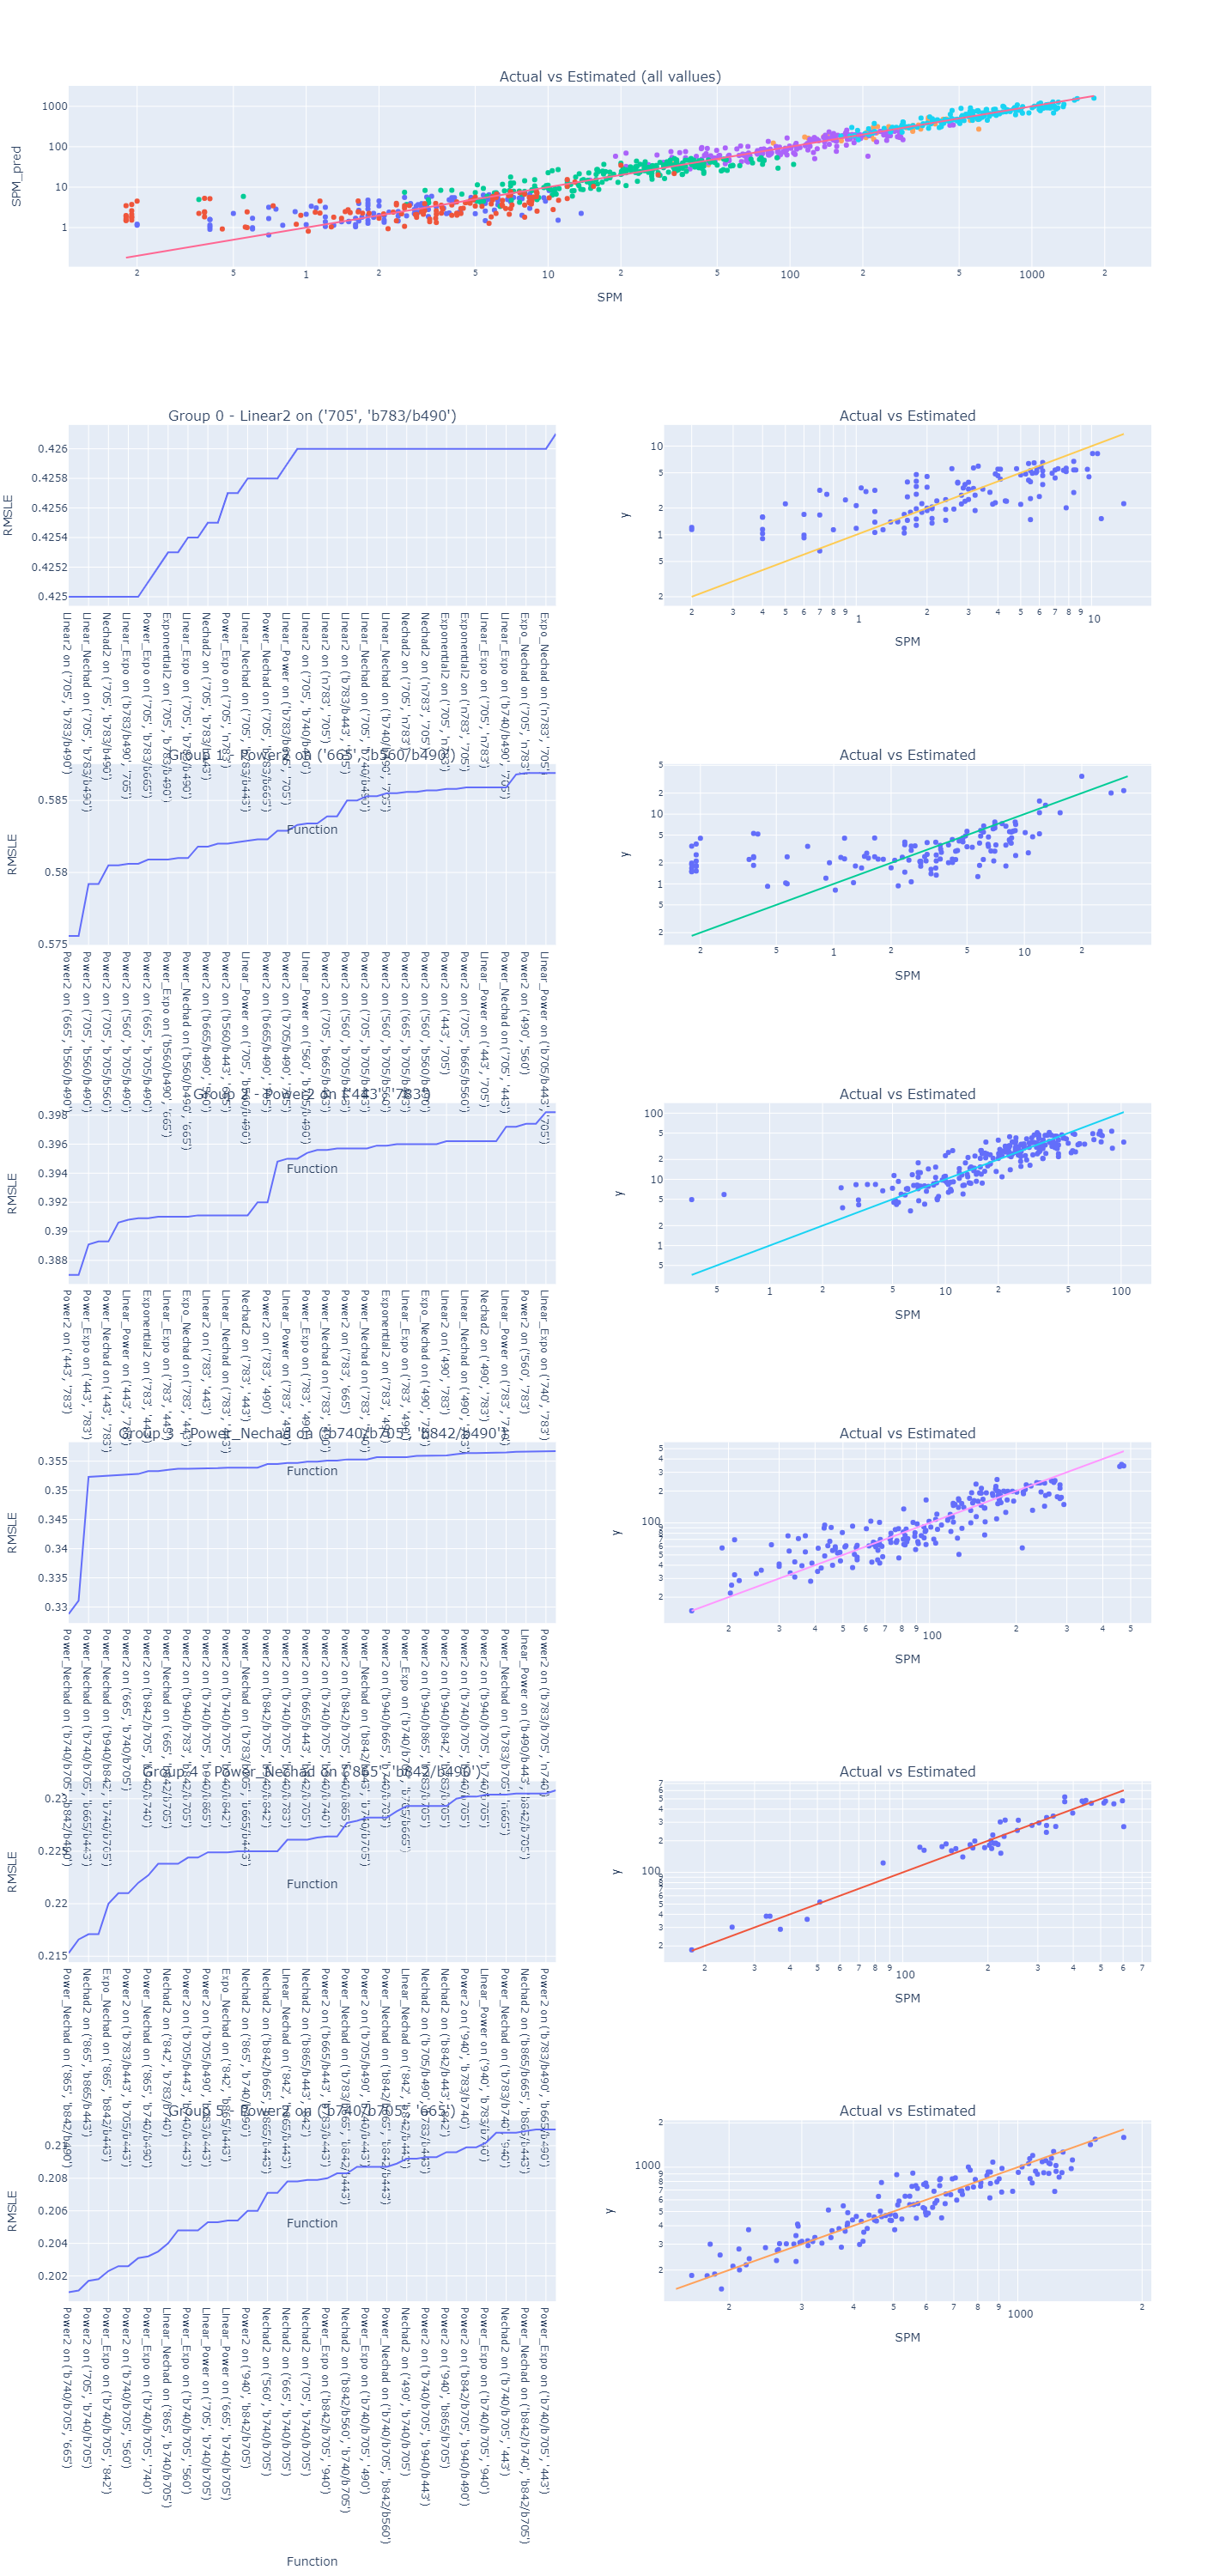

In [179]:
kmeans_nfuncs[6].group_fit.plot_groups_summary()

# Criar uma MultiFunction
poderia fazer multifunc(linear, linear) = regressao linear multipla 2 variaveis<br>
multifunc(linear, linear, linear) = regerssao linear 3 variaveis<br>
multifunc(linear, power, power)

In [161]:
import string

def multifunc(*funcs):
    # create a list of arguments
    arg_list = []
    for i, func in enumerate(funcs):
        arg_list.append([f'f{i}_{arg}' for arg in func.func.__code__.co_varnames[1:]])
        
        
        
    flat_args = [item for sublist in arg_list for item in sublist]

    s = f"def new_func(x, {','.join(flat_args)}): return "
    
    s_funcs = []
    for 
    
#         return f1(x[:, 0], a, b) + f2(x[:, 1], c, d)
    
    return s

In [162]:
multifunc(Functions.linear, Functions.linear)

'def new_func(x, f0_a,f0_b,f1_a,f1_b): return '

In [135]:
type(Functions.linear.func)

function

In [137]:
Functions.linear.func.__code__.co_varnames[1:]

('a', 'b')

In [80]:
for i in (2, 5):
    print(i)

2
5


In [120]:
x = BaseFit.parse_expr_df(high, ('865', '665'))

In [77]:
pd.DataFrame([BaseFit.parse_expr_df(high, 'b865/b665'), BaseFit.parse_expr_df(high, 'b865/b665')], ).T.to_numpy()

(311, 2)